In [1]:
!pip install -q efficientnet
import pandas as pd
import numpy as np
from scipy import stats
import random
import os
import tensorflow as tf
import math
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import re
import tensorflow.keras.applications.efficientnet as eff
import tensorflow.keras.applications as tfka
import efficientnet.tfkeras as efn
from sklearn import metrics
import gc
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
import tensorflow_addons as tfa
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
from matplotlib import pyplot as plt
%matplotlib inline

2021-12-05 20:25:38.551660: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-05 20:25:38.551770: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-05 20:25:44.229123: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-05 20:25:44.232096: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-05 20:25:44.232132: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-05 20:25:44.232159: I tensorflow/stream_executor/cuda/cud

In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2021-12-05 20:25:45.386400: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-05 20:25:45.408400: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-12-05 20:25:45.408449: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2021-12-05 20:25:45.433339: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-12-05 20:25:45.433401: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2021-12-05 20:25:45.433956: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30020


REPLICAS:  8


In [3]:
# Configuration
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 15
BATCH_SIZE = 32
IMAGE_SIZE = [256, 256]
# Seed
SEED = 9527
seed = 9527
# Learning rate
LR = 0.0005
# Verbosity
VERBOSE = 2
# Label_dim
label_dim = 35

# dataset path

img_path = '../input/deepfoodie/dataset_1_images/dataset_1_images/Food Images/'
GCS_PATH = KaggleDatasets().get_gcs_path('deepfoodiedataloaders')

train_set = tf.io.gfile.glob(GCS_PATH + '/train' + '*.tfrec')
val_set = tf.io.gfile.glob(GCS_PATH + '/val' + '*.tfrec')

TARGET = "cleaned_ingredients"
VOCAB_SIZE = 1871

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
# Data augmentation function
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return image, label

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image


# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "cleaned_ingredients": tf.io.FixedLenSequenceFeature([], dtype=tf.int64, allow_missing=True),
        "orig_ingredients": tf.io.FixedLenFeature([], tf.string),
#         "title": tf.io.FixedLenSequenceFeature([], dtype=tf.int64, allow_missing=True),
#         "instructions": tf.io.FixedLenFeature([], tf.string),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
#     title = example['title']
    label = example['cleaned_ingredients']
    return  image, label

def load_dataset(filenames, target, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames, target, ordered = False):
    dataset = load_dataset(filenames, target, ordered = ordered)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our validation tensors
def get_validation_dataset(filenames, target, ordered = True):
    dataset = load_dataset(filenames, target, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

# Function to count how many photos we have in
def count_data_items(filenames):
    # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(train_set)
print(f'Dataset: {NUM_TRAINING_IMAGES} training images')

Dataset: 10092 training images


In [5]:
train_dataset = get_training_dataset(train_set, TARGET, ordered = False)

In [6]:
for fo in train_dataset.take(1):
    continue
    print(fo[1], fo[0][1])
    print(fo[0][0].shape)

In [7]:
val_dataset = get_validation_dataset(val_set, TARGET, ordered = True)

2021-12-05 20:25:54.589590: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 31, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638735954.586269081","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 31, Output num: 0","grpc_status":3}


In [8]:
STEPS_PER_EPOCH = count_data_items(train_set) // BATCH_SIZE
K.clear_session()


In [9]:
def get_lr_callback():
    # lr_start   = 0.0000001
    # lr_max     = 0.000005 * BATCH_SIZE
    lr_min     = 0.0000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < EPOCHS/2:
            lr = 0.000001 * (BATCH_SIZE - epoch)
        else:
            lr = lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

In [10]:
def get_model(mode):

    with strategy.scope():

        inp = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3), name = 'inp1')
    #     inp2 = tf.keras.layers.Input(shape = (MAX_LEN,))
    #     print(f'load Model_{mode}')
    #     y = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inp2)
    #     y = tf.keras.layers.Dropout(.5)(y)
    #     y = tf.keras.layers.LSTM(128)(y)
        if mode == 'eff0':
            x = efn.EfficientNetB0(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff1':
            x = efn.EfficientNetB1(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff2':
            x = efn.EfficientNetB2(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff3':
            x = efn.EfficientNetB3(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff4':
            x = efn.EfficientNetB4(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff5':
            x = efn.EfficientNetB5(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff6':
            x = efn.EfficientNetB6(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff7':
            x = efn.EfficientNetB7(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'ICPV2':
            x = tfka.InceptionResNetV2(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'ICPV3':
            x = tfka.InceptionV3(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'XCP':
            x = tfka.Xception(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'VGG16':
            x = tfka.VGG16(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'VGG19':
            x = tfka.VGG19(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'RN50':
            x = tfka.ResNet50(weights = 'imagenet', include_top = False)(inp)
        else:
            # 'RN101'
            x = tfka.ResNet101(weights = 'imagenet', include_top = False)(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        x = tf.keras.layers.Dense(256)(x)

        output = tf.keras.layers.Dense(VOCAB_SIZE, activation='sigmoid')(x)

        model = tf.keras.models.Model(inputs = [inp], outputs = [output])
        opt = tf.keras.optimizers.Adam(learning_rate = LR)

        model.compile(
            optimizer = opt,
            loss="binary_crossentropy"

            ) 
        print(model.summary())
        return model

In [11]:
def plot_model(mode):
    model = get_model(mode=mode)
    print("===================")
    print("training model : {} ".format(mode))
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'Model_{mode}_{505}.h5', 
                                                        monitor = 'val_loss', 
                                                        verbose = 2, 
                                                        save_best_only = True,
                                                        save_weights_only = True, 
                                                        mode = 'min')
    history = model.fit(train_dataset,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            epochs = EPOCHS,
                            callbacks = [checkpoint, get_lr_callback()], 
                            validation_data = val_dataset,
                            verbose = VERBOSE)
    
    gc.collect()
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

27164672/27164032 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp1 (InputLayer)            [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnet-b1 (Functional) (None, None, None, 1280)  6575232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dense_1 (Dense)              (None, 1871)              480847    
Total params: 7,384,015
Trainable params: 7,321,967
Non-trainable params: 62,048
_________________________________________________________________
None
training model : eff1 
Epoch 1/15

Epoch 0

2021-12-05 20:27:44.478954: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 38731, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638736064.478680371","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 38731, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.06216, saving model to Model_eff1_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 18s - loss: 0.0224 - val_loss: 0.0427

Epoch 00002: val_loss improved from 0.06216 to 0.04274, saving model to Model_eff1_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 18s - loss: 0.0207 - val_loss: 0.0370

Epoch 00003: val_loss improved from 0.04274 to 0.03701, saving model to Model_eff1_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 18s - loss: 0.0204 - val_loss: 0.0316

Epoch 00004: val_loss improved from 0.03701 to 0.03163, saving model to Model_eff1_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 18s - loss: 0.0202 - val_loss: 0.0294

Epoch 00005: val_loss improved from 0.03163 to 0.02942, saving model to Model_eff1_505.h5
Epoch 6/15

Ep

2021-12-05 20:34:02.300709: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 126602, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638736442.300060697","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 126602, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.05793, saving model to Model_eff2_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 18s - loss: 0.0226 - val_loss: 0.0429

Epoch 00002: val_loss improved from 0.05793 to 0.04293, saving model to Model_eff2_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 18s - loss: 0.0207 - val_loss: 0.0355

Epoch 00003: val_loss improved from 0.04293 to 0.03551, saving model to Model_eff2_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 18s - loss: 0.0204 - val_loss: 0.0320

Epoch 00004: val_loss improved from 0.03551 to 0.03202, saving model to Model_eff2_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 19s - loss: 0.0202 - val_loss: 0.0301

Epoch 00005: val_loss improved from 0.03202 to 0.03012, saving model to Model_eff2_505.h5
Epoch 6/15

Ep

2021-12-05 20:40:48.133047: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 222184, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638736848.132642360","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 222184, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.06643, saving model to Model_eff3_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 21s - loss: 0.0225 - val_loss: 0.0444

Epoch 00002: val_loss improved from 0.06643 to 0.04437, saving model to Model_eff3_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 21s - loss: 0.0207 - val_loss: 0.0361

Epoch 00003: val_loss improved from 0.04437 to 0.03614, saving model to Model_eff3_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 21s - loss: 0.0203 - val_loss: 0.0349

Epoch 00004: val_loss improved from 0.03614 to 0.03486, saving model to Model_eff3_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 21s - loss: 0.0202 - val_loss: 0.0291

Epoch 00005: val_loss improved from 0.03486 to 0.02906, saving model to Model_eff3_505.h5
Epoch 6/15

Ep

2021-12-05 20:48:31.788244: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 329389, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638737311.787687039","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 329389, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.12579, saving model to Model_eff4_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 25s - loss: 0.0233 - val_loss: 0.0823

Epoch 00002: val_loss improved from 0.12579 to 0.08226, saving model to Model_eff4_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 25s - loss: 0.0209 - val_loss: 0.0651

Epoch 00003: val_loss improved from 0.08226 to 0.06512, saving model to Model_eff4_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 25s - loss: 0.0205 - val_loss: 0.0542

Epoch 00004: val_loss improved from 0.06512 to 0.05425, saving model to Model_eff4_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 25s - loss: 0.0203 - val_loss: 0.0411

Epoch 00005: val_loss improved from 0.05425 to 0.04106, saving model to Model_eff4_505.h5
Epoch 6/15

Ep

2021-12-05 20:58:02.050354: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 457086, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638737882.050136119","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 457086, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.04246, saving model to Model_eff5_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 30s - loss: 0.0223 - val_loss: 0.0255

Epoch 00002: val_loss improved from 0.04246 to 0.02551, saving model to Model_eff5_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 31s - loss: 0.0207 - val_loss: 0.0228

Epoch 00003: val_loss improved from 0.02551 to 0.02279, saving model to Model_eff5_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 30s - loss: 0.0204 - val_loss: 0.0220

Epoch 00004: val_loss improved from 0.02279 to 0.02197, saving model to Model_eff5_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 30s - loss: 0.0202 - val_loss: 0.0212

Epoch 00005: val_loss improved from 0.02197 to 0.02121, saving model to Model_eff5_505.h5
Epoch 6/15

Ep

2021-12-05 21:09:21.464737: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 595593, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638738561.464648504","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 595593, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.22681, saving model to Model_eff6_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 35s - loss: 0.0253 - val_loss: 0.1142

Epoch 00002: val_loss improved from 0.22681 to 0.11417, saving model to Model_eff6_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 35s - loss: 0.0216 - val_loss: 0.0698

Epoch 00003: val_loss improved from 0.11417 to 0.06975, saving model to Model_eff6_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 35s - loss: 0.0210 - val_loss: 0.0570

Epoch 00004: val_loss improved from 0.06975 to 0.05700, saving model to Model_eff6_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 35s - loss: 0.0206 - val_loss: 0.0351

Epoch 00005: val_loss improved from 0.05700 to 0.03514, saving model to Model_eff6_505.h5
Epoch 6/15

Ep

2021-12-05 21:22:47.129277: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 769062, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638739367.129116000","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 769062, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.20780, saving model to Model_eff7_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 45s - loss: 0.0248 - val_loss: 0.0702

Epoch 00002: val_loss improved from 0.20780 to 0.07025, saving model to Model_eff7_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 45s - loss: 0.0215 - val_loss: 0.0531

Epoch 00003: val_loss improved from 0.07025 to 0.05308, saving model to Model_eff7_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 45s - loss: 0.0210 - val_loss: 0.0379

Epoch 00004: val_loss improved from 0.05308 to 0.03792, saving model to Model_eff7_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 45s - loss: 0.0207 - val_loss: 0.0327

Epoch 00005: val_loss improved from 0.03792 to 0.03267, saving model to Model_eff7_505.h5
Epoch 6/15

Ep

2021-12-05 21:35:24.092229: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 870101, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638740124.092121790","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 870101, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.02653, saving model to Model_XCP_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 15s - loss: 0.0218 - val_loss: 0.0217

Epoch 00002: val_loss improved from 0.02653 to 0.02171, saving model to Model_XCP_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 14s - loss: 0.0204 - val_loss: 0.0209

Epoch 00003: val_loss improved from 0.02171 to 0.02087, saving model to Model_XCP_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 14s - loss: 0.0201 - val_loss: 0.0206

Epoch 00004: val_loss improved from 0.02087 to 0.02064, saving model to Model_XCP_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 15s - loss: 0.0200 - val_loss: 0.0205

Epoch 00005: val_loss improved from 0.02064 to 0.02049, saving model to Model_XCP_505.h5
Epoch 6/15

Epoch 0

2021-12-05 21:40:33.720068: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 952423, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638740433.719981130","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 952423, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.02262, saving model to Model_RN50_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 15s - loss: 0.0203 - val_loss: 0.0207

Epoch 00002: val_loss improved from 0.02262 to 0.02070, saving model to Model_RN50_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 15s - loss: 0.0198 - val_loss: 0.0201

Epoch 00003: val_loss improved from 0.02070 to 0.02012, saving model to Model_RN50_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 15s - loss: 0.0197 - val_loss: 0.0198

Epoch 00004: val_loss improved from 0.02012 to 0.01984, saving model to Model_RN50_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 15s - loss: 0.0197 - val_loss: 0.0198

Epoch 00005: val_loss improved from 0.01984 to 0.01975, saving model to Model_RN50_505.h5
Epoch 6/15

Ep

2021-12-05 21:48:11.959017: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 1078108, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638740891.958883466","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1078108, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.04324, saving model to Model_ICPV2_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 37s - loss: 0.0211 - val_loss: 0.0541

Epoch 00002: val_loss did not improve from 0.04324
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 35s - loss: 0.0203 - val_loss: 0.0507

Epoch 00003: val_loss did not improve from 0.04324
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 36s - loss: 0.0199 - val_loss: 0.0506

Epoch 00004: val_loss did not improve from 0.04324
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 35s - loss: 0.0199 - val_loss: 0.0559

Epoch 00005: val_loss did not improve from 0.04324
Epoch 6/15

Epoch 00006: LearningRateScheduler reducing learning rate to 2.7e-05.
315/315 - 34s - loss: 0.0198 - val_loss: 0.0522

Epoch 00006: val_loss did not improve 

2021-12-05 21:57:18.423753: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 1101545, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638741438.423229867","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1101545, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.02122, saving model to Model_VGG19_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 14s - loss: 0.0207 - val_loss: 0.0206

Epoch 00002: val_loss improved from 0.02122 to 0.02061, saving model to Model_VGG19_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 14s - loss: 0.0202 - val_loss: 0.0203

Epoch 00003: val_loss improved from 0.02061 to 0.02032, saving model to Model_VGG19_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 14s - loss: 0.0202 - val_loss: 0.0203

Epoch 00004: val_loss did not improve from 0.02032
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 14s - loss: 0.0200 - val_loss: 0.0202

Epoch 00005: val_loss improved from 0.02032 to 0.02018, saving model to Model_VGG19_505.h5
Epoch 6/15

Epoch 00006: LearningRateScheduler re

2021-12-05 22:01:19.572772: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 1134745, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638741679.572373780","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1134745, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.02116, saving model to Model_VGG16_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 13s - loss: 0.0207 - val_loss: 0.0205

Epoch 00002: val_loss improved from 0.02116 to 0.02051, saving model to Model_VGG16_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 12s - loss: 0.0202 - val_loss: 0.0203

Epoch 00003: val_loss improved from 0.02051 to 0.02030, saving model to Model_VGG16_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 12s - loss: 0.0201 - val_loss: 0.0202

Epoch 00004: val_loss improved from 0.02030 to 0.02024, saving model to Model_VGG16_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 12s - loss: 0.0200 - val_loss: 0.0201

Epoch 00005: val_loss improved from 0.02024 to 0.02011, saving model to Model_VGG16_505.h5
Epoch 6/1

2021-12-05 22:06:41.924919: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 1204504, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638742001.924316484","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1204504, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.45378, saving model to Model_RN101_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 23s - loss: 0.0203 - val_loss: 0.2038

Epoch 00002: val_loss improved from 0.45378 to 0.20383, saving model to Model_RN101_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 23s - loss: 0.0198 - val_loss: 0.0224

Epoch 00003: val_loss improved from 0.20383 to 0.02238, saving model to Model_RN101_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 23s - loss: 0.0197 - val_loss: 0.0200

Epoch 00004: val_loss improved from 0.02238 to 0.01998, saving model to Model_RN101_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 23s - loss: 0.0196 - val_loss: 0.0198

Epoch 00005: val_loss improved from 0.01998 to 0.01978, saving model to Model_RN101_505.h5
Epoch 6/1

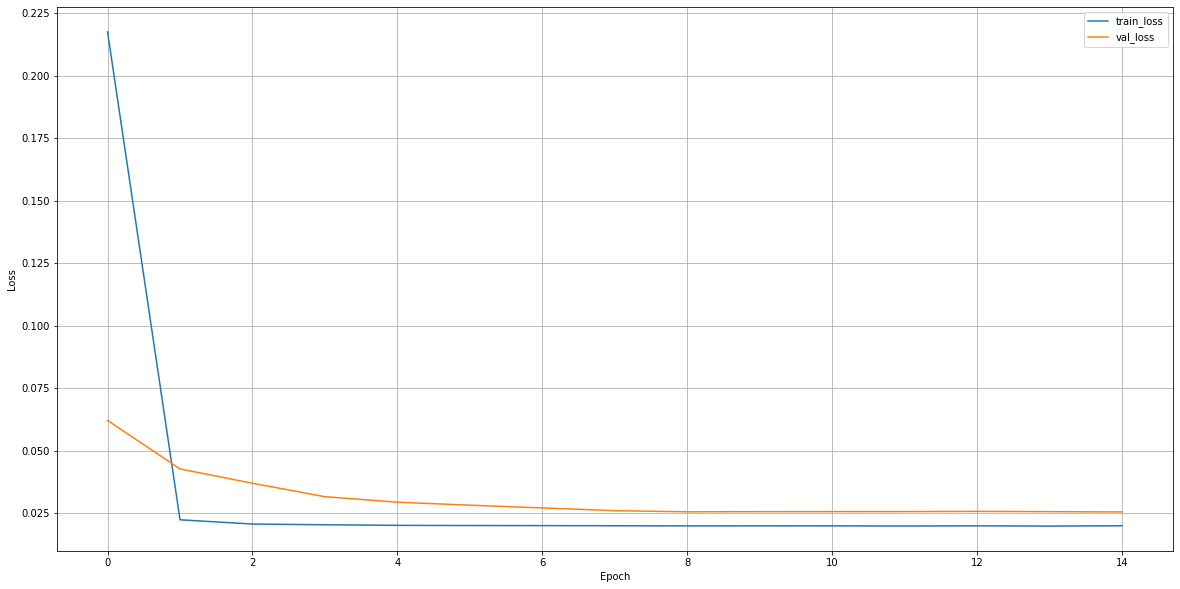

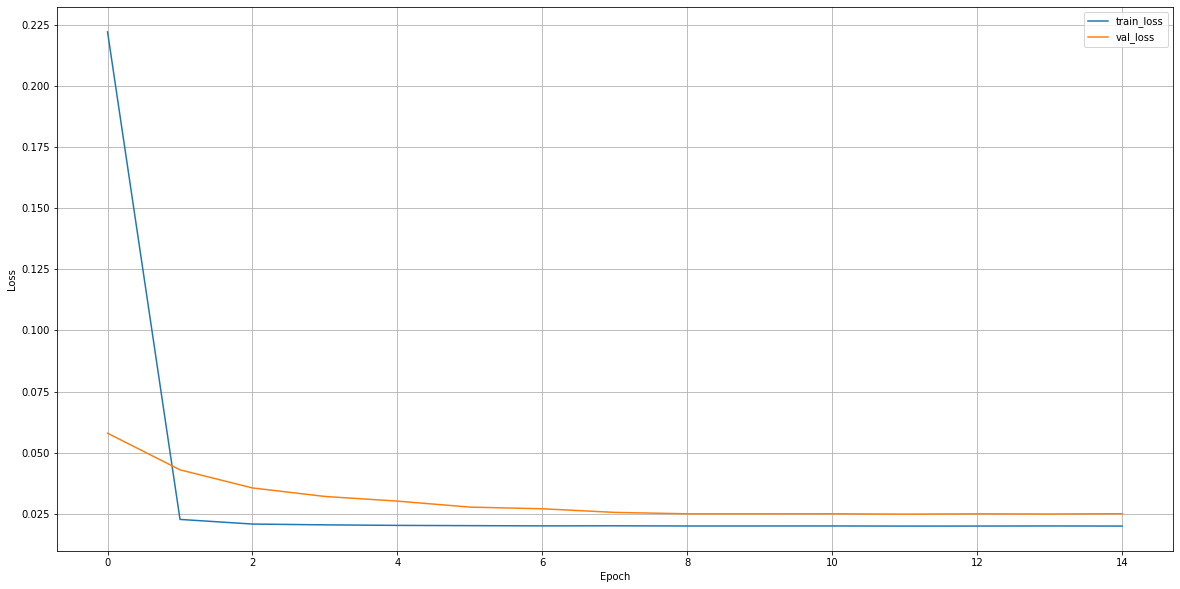

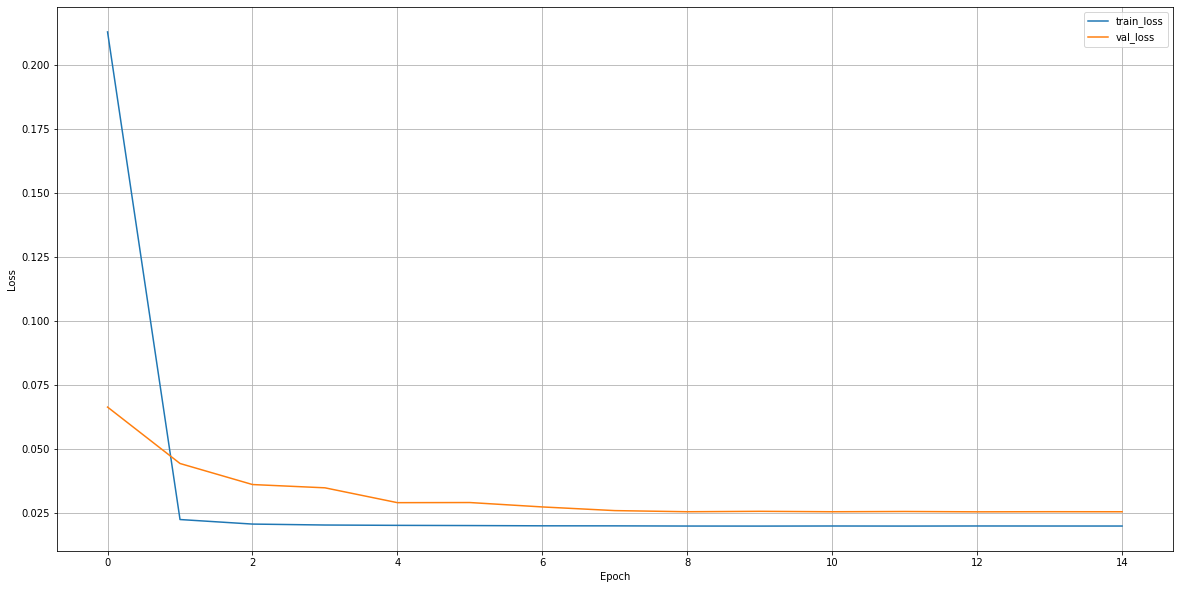

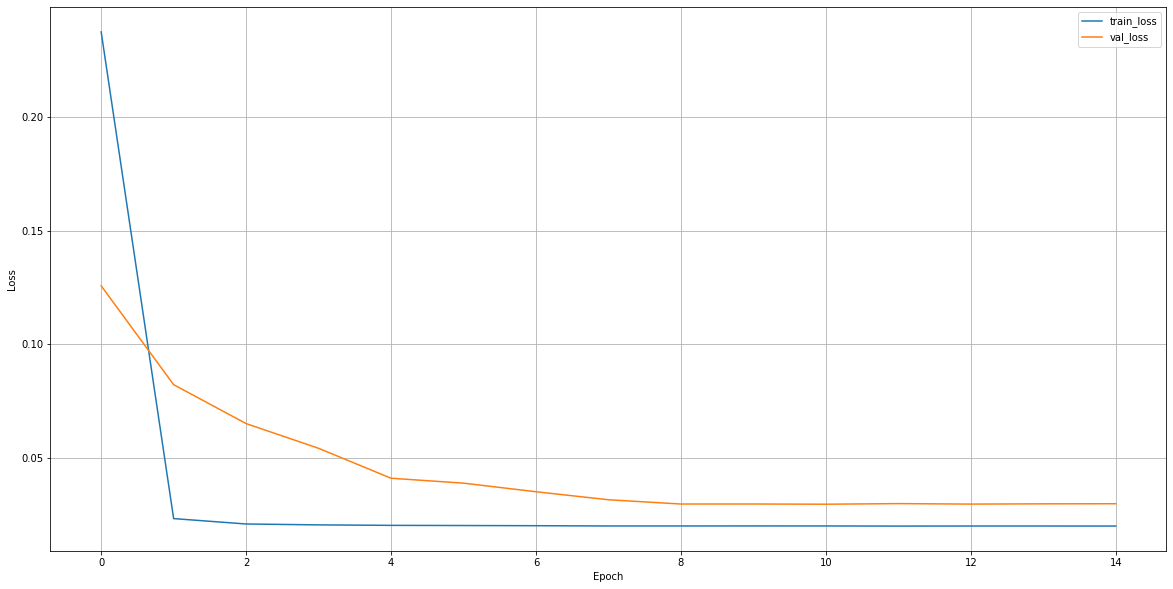

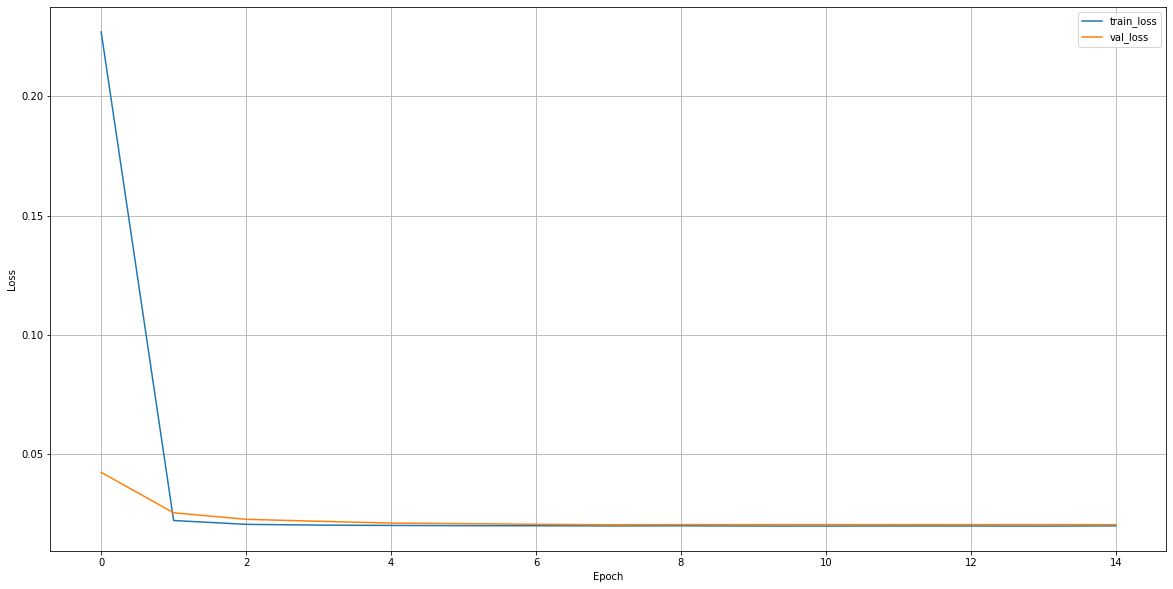

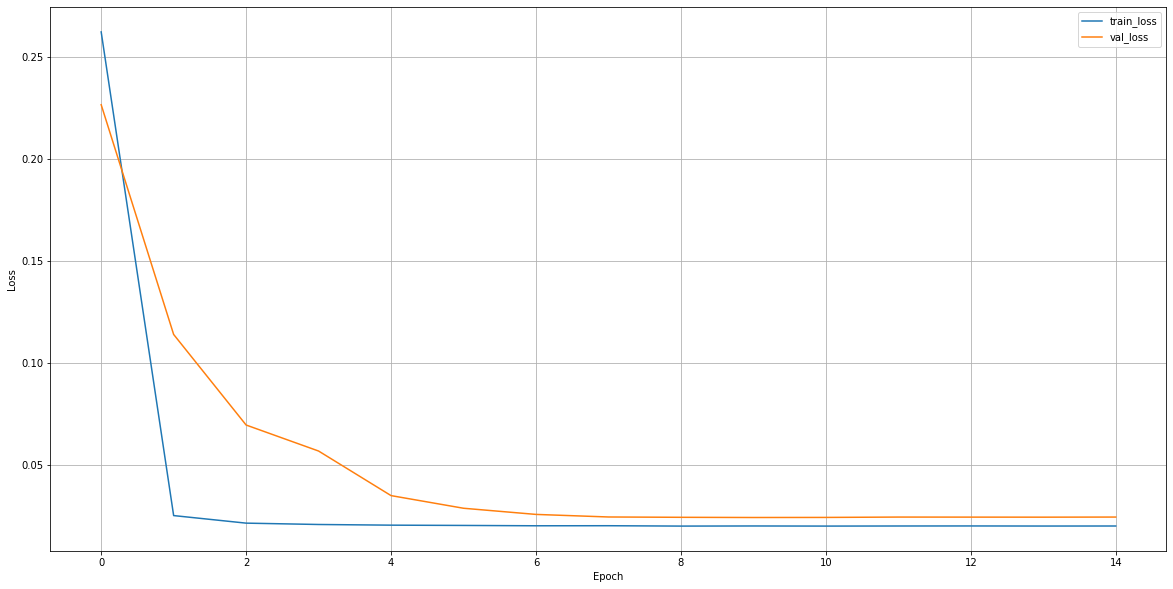

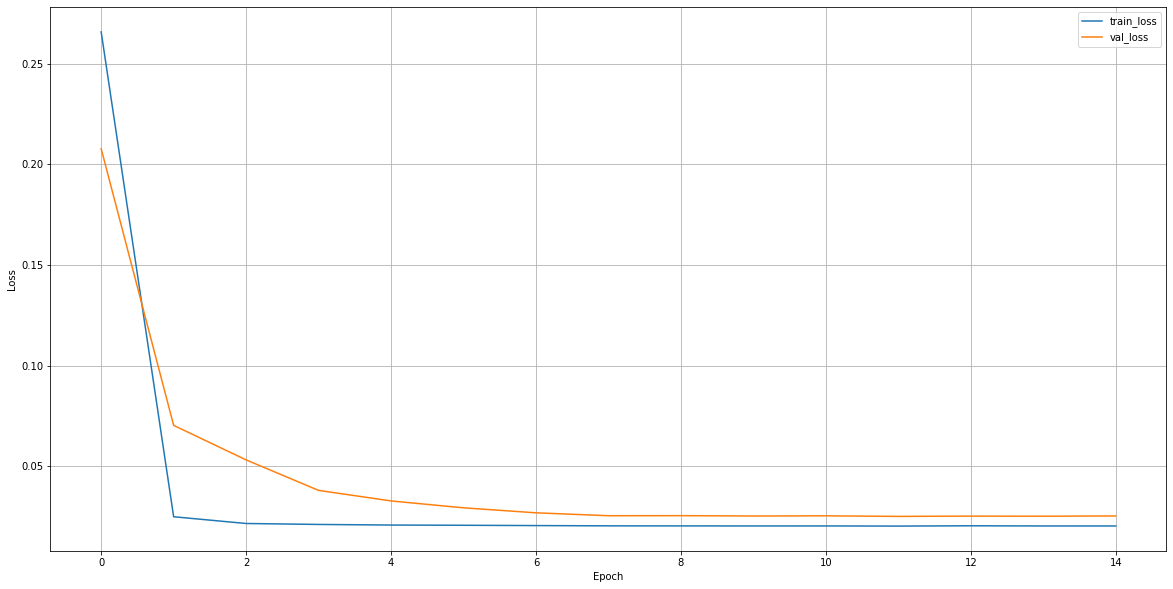

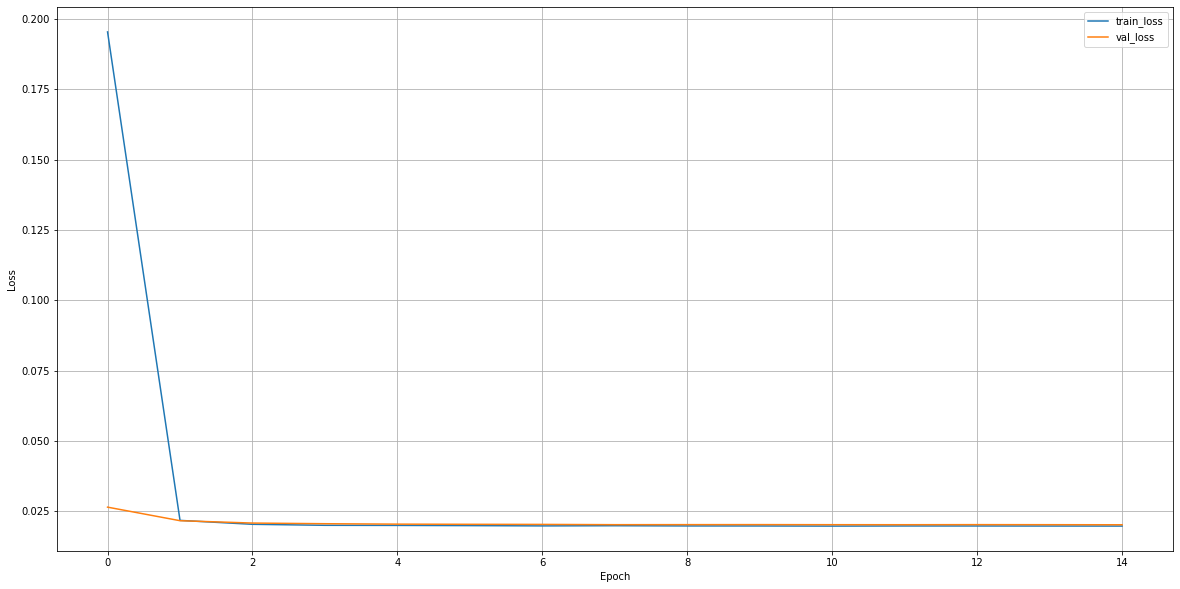

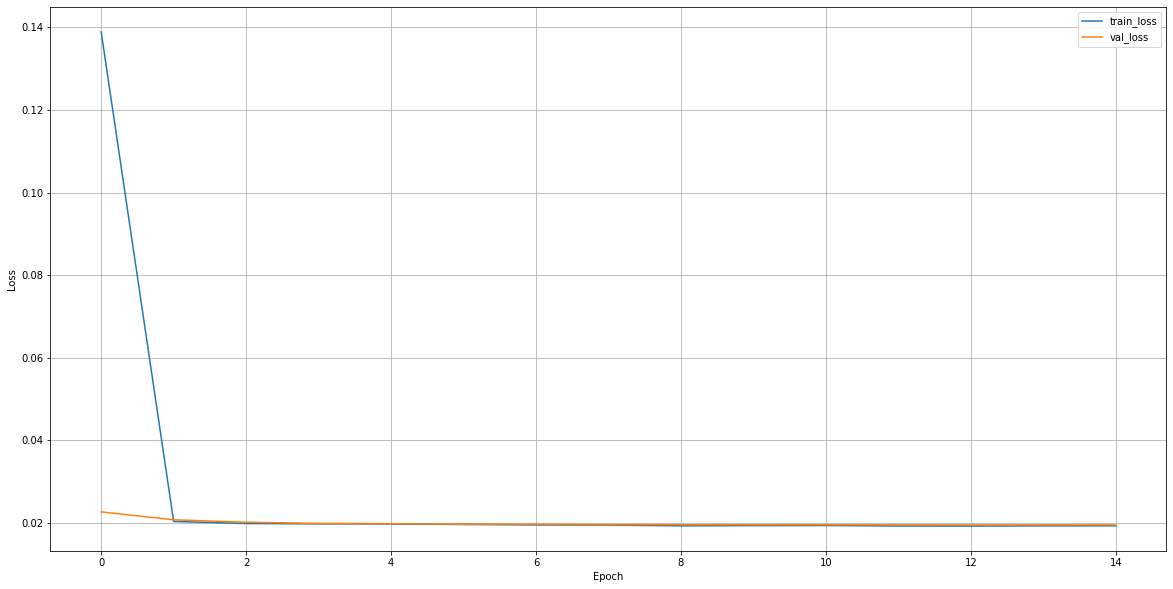

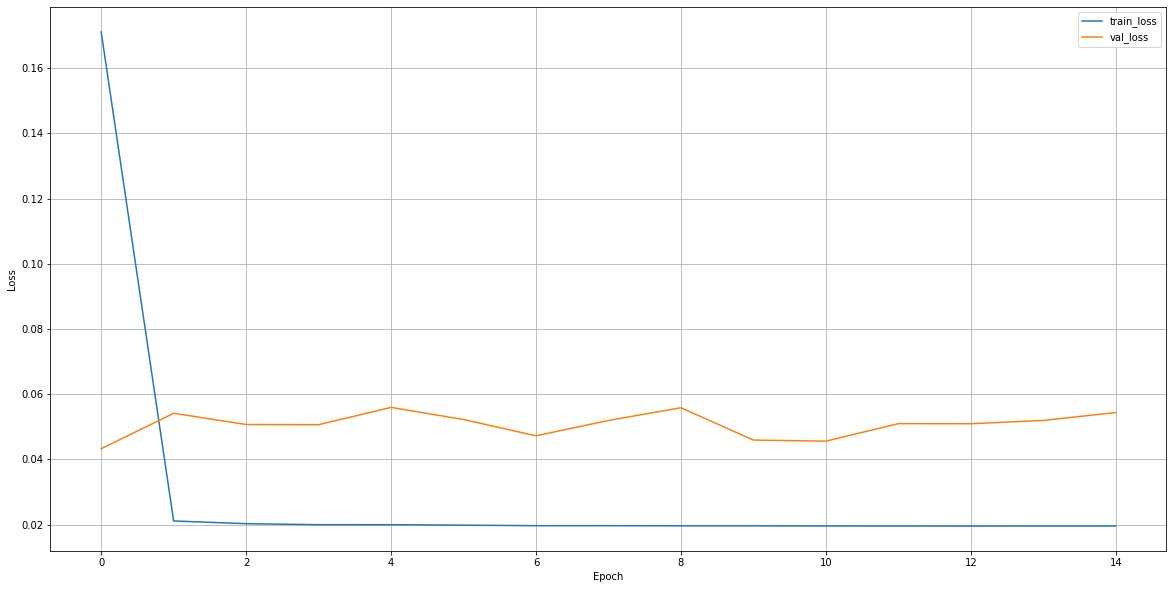

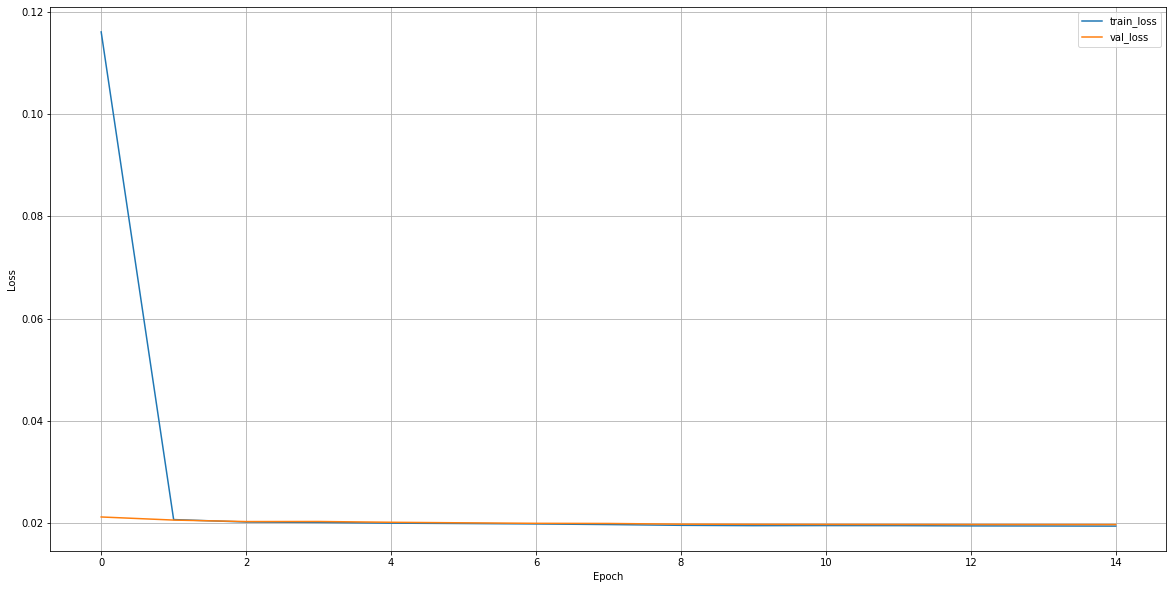

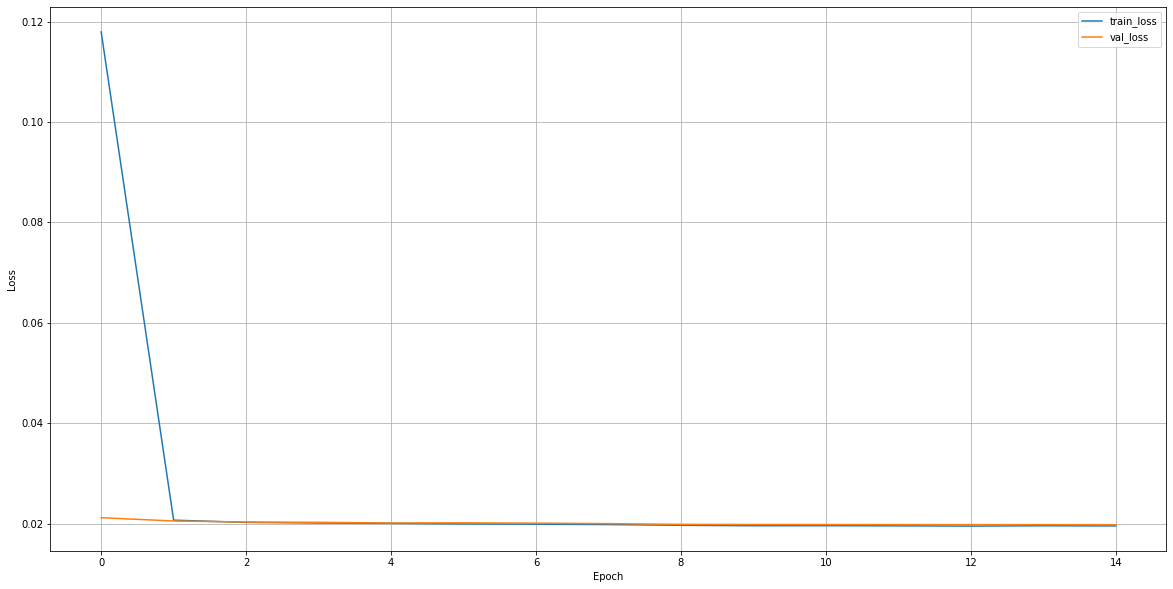

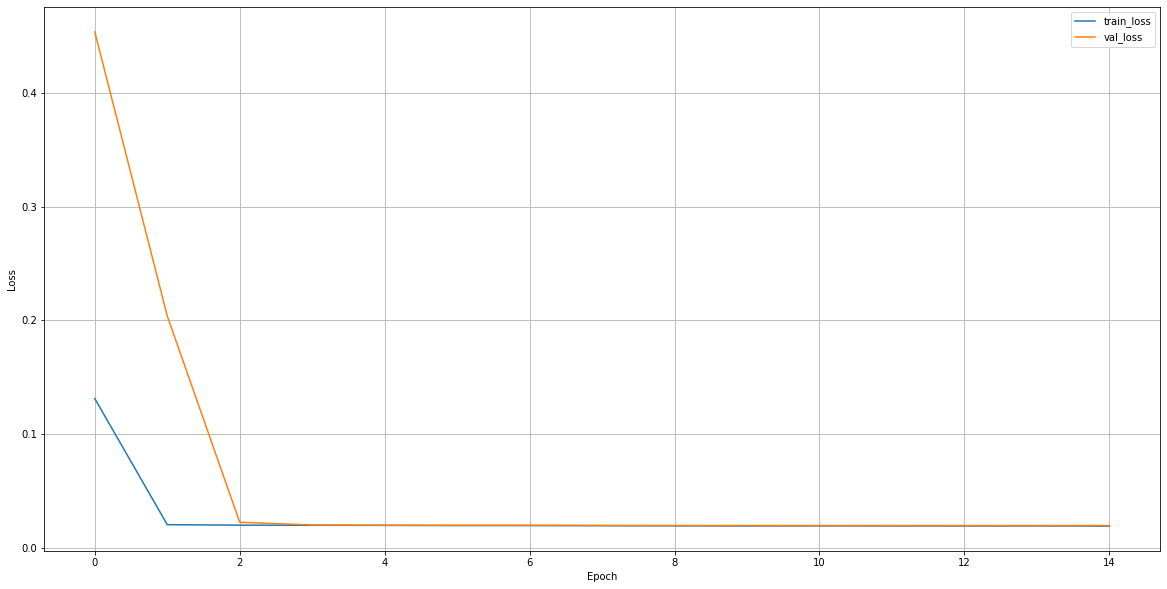

In [12]:
models = ['eff1','eff2','eff3','eff4','eff5','eff6','eff7','XCP', 'RN50', 'ICPV2', 'VGG19', 'VGG16', 'RN101']
for mode in models: plot_model(mode)

In [13]:
# plot_model(models[1])

In [14]:
# plot_model(models[2])

In [15]:
# plot_model(models[3])

In [16]:
# plot_model(models[4])

In [17]:
# plot_model(models[5])

In [18]:
# plot_model(models[6])

In [19]:
# plot_model(models[7])

In [20]:
# plot_model(models[8])